In [133]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder

In [134]:
def plot_surface(cls, x_1, x_2, ax=None, threshold=0.5, contourf=False):
    xx1, xx2 = np.meshgrid(np.linspace(x_1.min(), x_1.max(), 100), 
                           np.linspace(x_2.min(), x_2.max(), 100))

    X_pred = np.c_[xx1.ravel(), xx2.ravel()]
    pred = cls.predict_proba(X_pred)[:, 0]
    Z = pred.reshape((100, 100))
    if ax is None:
        ax = plt.gca()
    ax.contour(xx1, xx2, Z, levels=[threshold], colors='black')
    ax.set_xlim((x_1.min(), x_1.max()))
    ax.set_ylim((x_2.min(), x_2.max()))

In [135]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1), cmap=cm_bright)

In [136]:
class NeuralNet:
    
    def __init__(self, layers_sizes, normalize = True, learning_rate = 0.01, num_iter = 15000, costs_iters=300, tol=1e-7):
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.layers_sizes = layers_sizes
        self.tol = tol
        self.layers = len(layers_sizes) + 1
        self.costs_iters = costs_iters
    
    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s
    
    def __softmax(self, Z):
        e = np.exp(Z)
        return e/np.sum(e, axis=0, keepdims=True)
    
    def __relu(self, Z):
        return np.maximum(0,Z)
    
    def __relu_derivative(self, A):
        return np.greater_equal(A, 0).astype(int)
    
    def __initialize_parameters(self):
        W, b = [], []
        
        for l in range(1,self.layers+1):
            W_l = np.random.randn(self.layers_sizes[l], self.layers_sizes[l-1]) * 0.01
            b_l = np.zeros((self.layers_sizes[l], 1))
            W.append(W_l)
            b.append(b_l)
        
        self.parameters = {"W" : W, "b" : b}
        
        for key in self.parameters:
            for key_i,i in zip(self.parameters[key],range(len(self.parameters[key]))):
                print("{}{}: {}".format(key,i+1,key_i.shape))
       
    def __forward_propagation(self, X):            
        W = self.parameters["W"]
        b = self.parameters["b"]
        Z, A = [], [] 

        A.append(X)
        for l in range(0,self.layers-1):
            Z_l = np.dot(W[l],A[l]) + b[l]
            A_l = self.__relu(Z_l)
            Z.append(Z_l)
            A.append(A_l)
        
        l = self.layers-1
        Z_l = np.dot(W[l],A[l]) + b[l]
        A_l = self.__softmax(Z_l)
        Z.append(Z_l)
        A.append(A_l)
        
        cache = (Z,A)
        return A[-1], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        return J
    
    def __backward_propagation(self, X, Y, cache):
        m = X.shape[1]
        
        W = self.parameters["W"]
        b = self.parameters["b"]
        (Z,A) = cache
        
        dZ, dW, db = [], [], []
        
        dZ_l = A[-1] - Y
        dW_l = 1. / m * np.dot(dZ_l, A[-2].T)
        db_l = 1. / m * np.sum(dZ_l, axis = 1, keepdims = True)
        
        dZ.insert(0,dZ_l)
        dW.insert(0,dW_l)
        db.insert(0,db_l)
        
        for l in range(self.layers-1,0,-1):
            dA_l = np.dot(W[l].T,dZ_l)
            dZ_l = np.multiply(dA_l, self.__relu_derivative(A[l]))
            dW_l = 1. / m * np.dot(dZ_l, A[l-1].T)
            db_l = 1. / m * np.sum(dZ_l, axis = 1, keepdims = True)
            dZ.insert(0,dZ_l)
            dW.insert(0,dW_l)
            db.insert(0,db_l)
        
        grads = {"dZ":dZ,"dW":dW,"db":db}
        return grads
  
    
    def __update_parameters(self, grads):        
        W = self.parameters["W"]
        b = self.parameters["b"]
        dW = grads["dW"]
        db = grads["db"]
    
        for l in range(0,len(W)):
            W[l] = W[l] - self.learning_rate * dW[l]
            b[l] = b[l] - self.learning_rate * db[l]
            
        self.parameters["W"] = W
        self.parameters["b"] = b

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        Y = Y.reshape((Y.shape[0], 1))
        enc = OneHotEncoder(handle_unknown='ignore')
        self.enc = enc
        Y = enc.fit_transform(Y).toarray().astype(int).T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        costs_imp = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        C = Y.shape[0]
        
        self.layers_sizes.insert(0,n_x)
        self.layers_sizes.append(C);
        
        self.__initialize_parameters()

        for i in range(self.num_iter):
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)
            
            grads = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(grads)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)
            
            costs_imp.append(cost)
            if i > self.costs_iters:
                len_imp = len(costs_imp)-1
                if abs(costs_imp[len_imp] - costs_imp[len_imp-self.costs_iters]) < self.tol:
                    print("Stop iteration: {}".format(i))
                    break;

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_propagation(X)[0].T
        return probs
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        max_cols = positive_probs.max(axis=1).reshape((-1,1))
        pred = (positive_probs == max_cols).astype(int)
        pred = self.enc.inverse_transform(pred)
        pred = pred.reshape((-1,)).T
        return pred

In [137]:
X, Y = load_iris(return_X_y = True)

In [140]:
cls = NeuralNet(layers_sizes = [30,20,5], normalize = True, learning_rate = 0.1, num_iter = 15000, tol = 1e-8, costs_iters=1000)

W1: (30, 4)
W2: (20, 30)
W3: (5, 20)
W4: (3, 5)
b1: (30, 1)
b2: (20, 1)
b3: (5, 1)
b4: (3, 1)
0-th iteration: 1.909542560306416
1000-th iteration: 1.9095423611322968
2000-th iteration: 1.9095421337381213
3000-th iteration: 1.9095418649157756
4000-th iteration: 1.9095415595117948
5000-th iteration: 1.9095410953772551
6000-th iteration: 1.909540258117246
7000-th iteration: 1.9095384735009733
8000-th iteration: 1.9095337352762114
9000-th iteration: 1.9095135345208225
10000-th iteration: 1.9088604961917897
11000-th iteration: 0.15117430482113758
12000-th iteration: 0.09865885769550849
13000-th iteration: 0.09113853342206993
14000-th iteration: 0.08698113884000179


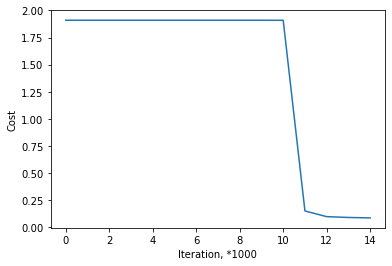

In [141]:
cls.fit(X, Y)

In [142]:
print(cls1.parameters)

{'W': [array([[-3.21510252e-01, -2.64316558e-01],
       [-9.68591623e-01, -7.41825422e-01],
       [-1.29441934e-01, -7.72544933e-02],
       [ 2.44864782e-01,  2.30498519e-01],
       [-4.88251268e-01, -3.99451247e-01],
       [-3.02059214e-01, -2.38784579e-01],
       [ 4.01046272e-01,  3.88939888e-01],
       [-5.69577783e-02, -6.72085560e-05],
       [-6.01721807e-04,  3.57922980e-02],
       [ 2.75069563e-01,  2.77488984e-01],
       [ 4.25742060e-01,  4.17458458e-01],
       [-2.05670461e-01, -1.69508307e-01],
       [-2.04817782e-01, -1.60197770e-01],
       [ 6.28701331e-01,  5.76256624e-01],
       [ 8.19256691e-02,  9.23199566e-02],
       [ 1.47757110e-01,  1.59672723e-01],
       [-5.35295558e-01, -4.53258721e-01],
       [-2.32897892e-01, -1.94352062e-01],
       [-2.92375593e-01, -2.32767535e-01],
       [-9.48741232e-01, -7.32551886e-01],
       [-1.18317566e-01, -7.01045045e-02],
       [-4.29572412e-01, -3.59638648e-01],
       [-1.11252577e-01, -1.08502485e-01],
    

In [143]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[9.99999269e-01, 7.28765078e-07, 2.07707637e-09],
       [9.99993623e-01, 6.36168471e-06, 1.51976414e-08],
       [9.99998928e-01, 1.06859913e-06, 2.95214324e-09],
       [9.99996475e-01, 3.51662734e-06, 8.81666342e-09],
       [9.99999628e-01, 3.70510009e-07, 1.11583333e-09],
       [9.99996137e-01, 3.85377671e-06, 9.59014701e-09],
       [9.99998713e-01, 1.28327177e-06, 3.49272354e-09],
       [9.99998437e-01, 1.55853188e-06, 4.17527916e-09],
       [9.99995575e-01, 4.41398296e-06, 1.08634367e-08],
       [9.99997661e-01, 2.33301887e-06, 6.04803830e-09],
       [9.99999307e-01, 6.90724020e-07, 1.97727147e-09],
       [9.99998301e-01, 1.69455772e-06, 4.50884785e-09],
       [9.99997887e-01, 2.10706846e-06, 5.50781152e-09],
       [9.99999757e-01, 2.42671479e-07, 7.56467901e-10],
       [9.99999916e-01, 8.40119394e-08, 2.85524582e-10],
       [9.99999778e-01, 2.21796440e-07, 6.96480358e-10],
       [9.99999311e-01, 6.87308196e-07, 1.96828821e-09],
       [9.99998146e-01, 1.84952

In [144]:
Y_hat = cls.predict(X)
Y_hat

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [145]:
accuracy_score(Y, Y_hat)

0.9866666666666667